# Double pendulum simulation

In [6]:
%matplotlib inline

import sys
import os

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from utils import DoublePendulum
from utils import calc_double_E, verification



L1, L2 = 1, 1
M1, M2 = 1, 1
init_theta1, init_omega1 = np.random.uniform(-3*np.pi/7, 3*np.pi/7), 0
init_theta2, init_omega2 = np.random.uniform(-3*np.pi/4, 3*np.pi/4), 0

dp = DoublePendulum(L1, L2, M1, M2, init_theta1, init_omega1, init_theta2, init_omega2)
t, y = dp.generate(tmax=300, dt=0.0001)

dp_params = {'M1': dp.M1, 'M2': dp.M2, 'L1': dp.L1, 'L2': dp.L2, 'g': dp.g}
V, T, E = calc_double_E(y, **dp_params)

Length (L1,L2) and Mass (M1,M2) of a string: (1,1) (1,1)
Initial theta(degree): -0.111098(-6.365465),2.237146(128.179001)
Initial omega: 0.000000,0.000000


Text(0, 0.5, 'Velocity (rad/s)')

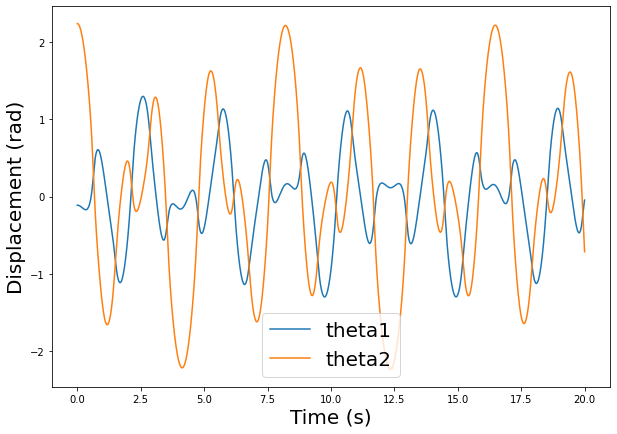

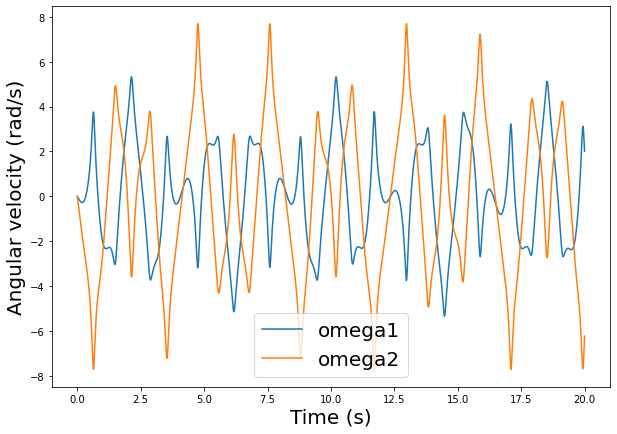

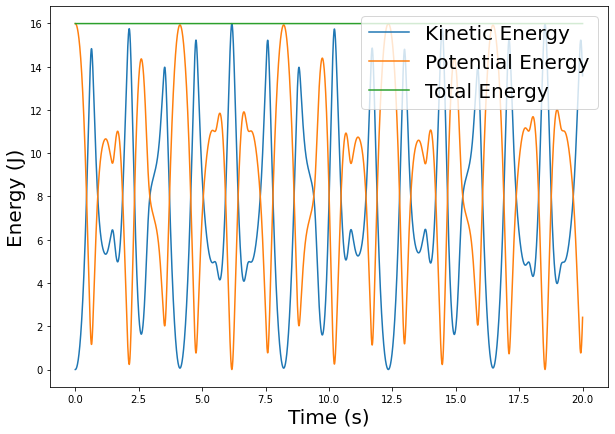

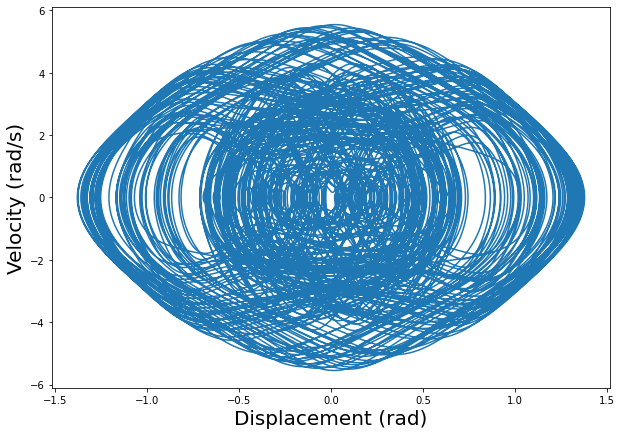

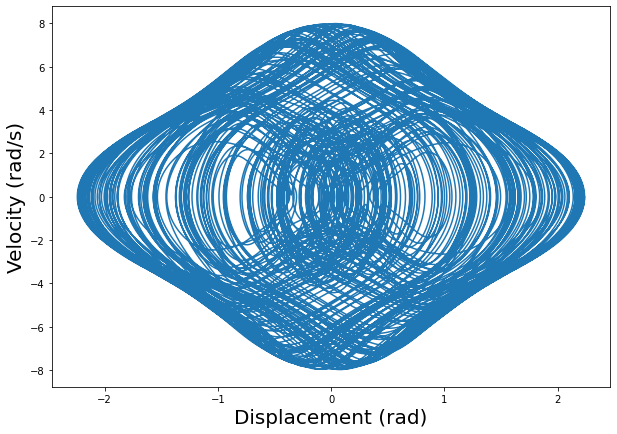

In [7]:
'''Plotting'''
# Unpack z and theta as a function of time
theta1, theta2 = y[:,0], y[:,2]
omega1, omega2 = y[:,1], y[:,3]

plt.figure(0, figsize=(10,7))
plt.plot(t[:200000], theta1[:200000], label='theta1')
plt.plot(t[:200000], theta2[:200000], label='theta2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Displacement (rad)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(t[:200000], omega1[:200000], label='omega1')
plt.plot(t[:200000], omega2[:200000], label='omega2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Angular velocity (rad/s)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(2, figsize=(10,7))
plt.plot(t[:200000], T[:200000], label='Kinetic Energy')
plt.plot(t[:200000], V[:200000], label='Potential Energy')
plt.plot(t[:200000], E[:200000], label='Total Energy')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Energy (J)', fontsize=20)

plt.figure(3, figsize=(10,7))
plt.plot(theta1, omega1)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

plt.figure(4, figsize=(10,7))
plt.plot(theta2, omega2)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

In [8]:
'''
Data preprocessing for NN
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset


device = torch.device("cuda:0")


sampling_step = 100    # sample a row for every the step.
sampling_ind = np.arange(0, t.shape[0]-1, sampling_step)
scaler = 1.0
scaled_y = np.array(y)
# scaled_y[:,1] = scaled_y[:,1]*scaler

input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
X = torch.tensor(input_output_y[sampling_ind], dtype=torch.float32, device=device)

num_samples = X.shape[0]
input_dim = 4
train_x, train_y = X[:int(num_samples*0.6), :input_dim], X[:int(num_samples*0.6), input_dim:]
val_x, val_y = X[int(num_samples*0.6):int(num_samples*0.7), :input_dim], X[int(num_samples*0.6):int(num_samples*0.7), input_dim:]
test_x, test_y = X[int(num_samples*0.7):, :input_dim], X[int(num_samples*0.7):, input_dim:]

train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=32, shuffle=True)
# val_loader = DataLoader(TensorDataset(val_x, val_y), batch_size=val_x.shape[0])
# test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=test_x.shape[0])

print("data size: {}/{}/{}".format(len(train_x), len(val_x), len(test_x)))

data size: 18000/3000/9000


In [30]:
class RuleEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RuleEncoder, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim,32),
                                 nn.ReLU(),
                                 nn.Linear(32,output_dim),
                                 nn.Tanh())
        
    def forward(self, x):
        return self.net(x)

    
class DataEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DataEncoder, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim,32),
                                 nn.ReLU(),
                                 nn.Linear(32,output_dim),
                                 nn.Tanh())
        
    def forward(self, x):
        return self.net(x)


class Net(nn.Module):
    def __init__(self, input_dim, output_dim, rule_encoder, data_encoder):
        super(Net, self).__init__()
        self.rule_encoder = rule_encoder
        self.data_encoder = data_encoder
        self.net = nn.Sequential(nn.Linear(input_dim,32),
                                 nn.ReLU(),
                                 nn.Linear(32,output_dim))
        
    def forward(self, x, alpha=0.0):
        rule_z = self.rule_encoder(x)
        data_z = self.data_encoder(x)
        
#         z = alpha*rule_z + (1-alpha)*data_z    # merge: Add
        z = torch.cat((alpha*rule_z, (1-alpha)*data_z), dim=-1)    # merge: Concat
        
#         return self.net(z) + x    # predict delta instead of absolute values
        return self.net(z)    # predict absolute values
    

# input_dim = 4
hidden_dim = 16
output_dim = 4

lr = 0.0001
rule_encoder = RuleEncoder(input_dim, hidden_dim)
data_encoder = DataEncoder(input_dim, hidden_dim)
model = Net(hidden_dim*2, output_dim, rule_encoder, data_encoder).to(device)

rule_weight = torch.tensor(model.rule_encoder.net[0].weight)
data_weight = torch.tensor(model.data_encoder.net[0].weight)

total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

loss_rule = lambda x,y: torch.mean(F.relu(x-y))
loss_task = nn.L1Loss()    # return scalar (reduction=mean)
optimizer = optim.Adam(model.parameters(), lr=lr)


epochs = 50
log_interval = 200
val_freq = 5
saved_filename = 'dp_{:.4f}_{:.1f}_{:.4f}_{:.1f}.pt'.format(init_theta1, init_omega1, init_theta2, init_omega2)
saved_filename =  os.path.join('saved_models', saved_filename)
print('saved_filename: {}'.format(saved_filename))
best_val_loss = 99999.

alpha = 0.0

# Training
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        batch_train_x = batch_data[0]
        batch_train_y = batch_data[1]
        
        optimizer.zero_grad()
        alpha = torch.rand(1).item()
#         alpha = 0.0    # data-only
        output = model(batch_train_x, alpha=alpha)    # only rule if alpha=1
        
        _, _, curr_E = calc_double_E(batch_train_x, **dp_params)
        _, _, pred_E = calc_double_E(output, **dp_params)
        _, _, target_E = calc_double_E(batch_train_y, **dp_params)
                
        loss_state = loss_task(output, batch_train_y)    # state prediction
#         loss_energy = loss_task(pred_E, target_E)    # energy prediction
        loss_cons = loss_rule(pred_E, curr_E)    # energy conservation

        
    
        loss = alpha*loss_cons + (1-alpha)*loss_state    # energy conservation + state prediction
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % log_interval == 0:
            print('[Train] Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} (alpha: {})'.format(
                epoch, batch_idx * len(batch_train_x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), alpha))
            
    # Evaluate on validation set
    if epoch % val_freq == 0:
        model.eval()
        with torch.no_grad():
            target = val_y
            output = model(val_x, alpha=0.0)
            val_loss = loss_task(output, target).item()
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print('[Valid] Epoch: {} Loss: {:.6f} (alpha: 0.0)\t best model is updated'.format(
                epoch, best_val_loss))
            torch.save({
                'epoch': epoch,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss
            }, saved_filename)
        else:
            print('[Valid] Epoch: {} Loss: {:.6f} (alpha: 0.0)'.format(epoch, best_val_loss))
            
            
        

# Test
rule_encoder = RuleEncoder(input_dim, hidden_dim)
data_encoder = DataEncoder(input_dim, hidden_dim)
model_eval = Net(hidden_dim*2, output_dim, rule_encoder, data_encoder).to(device)

checkpoint = torch.load(saved_filename)
model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t epoch: {}".format(checkpoint['epoch'], checkpoint['loss']))

model_eval.eval()
with torch.no_grad():
    target = test_y
    output = model_eval(test_x, alpha=0.0)
    test_loss = loss_task(output, target).item()  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))

/opt/conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


total parameters: 2564
saved_filename: saved_models/dp_-0.1111_0.0_2.2371_0.0.pt
[Train] Epoch: 1 [0/18000 (0%)]	Loss: 1.097964 (alpha: 0.23444503545761108)
[Train] Epoch: 1 [6400/18000 (36%)]	Loss: 0.944533 (alpha: 0.2811172604560852)
[Train] Epoch: 1 [12800/18000 (71%)]	Loss: 0.377350 (alpha: 0.7427346706390381)
[Train] Epoch: 2 [0/18000 (0%)]	Loss: 0.399365 (alpha: 0.6386798024177551)
[Train] Epoch: 2 [6400/18000 (36%)]	Loss: 1.044710 (alpha: 0.1284838318824768)
[Train] Epoch: 2 [12800/18000 (71%)]	Loss: 0.078746 (alpha: 0.9140344262123108)
[Train] Epoch: 3 [0/18000 (0%)]	Loss: 0.488319 (alpha: 0.38462358713150024)
[Train] Epoch: 3 [6400/18000 (36%)]	Loss: 0.125647 (alpha: 0.8404962420463562)
[Train] Epoch: 3 [12800/18000 (71%)]	Loss: 0.371203 (alpha: 0.42287498712539673)
[Train] Epoch: 4 [0/18000 (0%)]	Loss: 0.016021 (alpha: 0.9716984033584595)
[Train] Epoch: 4 [6400/18000 (36%)]	Loss: 0.160641 (alpha: 0.5260998606681824)
[Train] Epoch: 4 [12800/18000 (71%)]	Loss: 0.153693 (alpha: 

In [28]:
# Test
rule_encoder = RuleEncoder(input_dim, hidden_dim)
data_encoder = DataEncoder(input_dim, hidden_dim)
model = Net(hidden_dim*2, output_dim, rule_encoder, data_encoder).to(device)


In [24]:
model_eval.rule_encoder.net[0].weight[:5]

tensor([[-0.0172, -0.0032,  0.5892, -0.1982],
        [-0.1834, -0.1478,  0.2455,  0.2101],
        [-0.2626, -0.0113,  0.1512, -0.1536],
        [ 0.6498, -0.1700, -0.2377,  0.0361],
        [ 0.0196, -0.2010, -0.2057,  0.2192]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [29]:
model.rule_encoder.net[0].weight[:5]

tensor([[-0.0665, -0.4115,  0.2301, -0.3419],
        [ 0.4977,  0.0152,  0.2769,  0.0817],
        [-0.2886,  0.2129,  0.4376,  0.1041],
        [-0.3439, -0.0270,  0.0035, -0.3445],
        [-0.1110,  0.2453,  0.0101, -0.4018]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [299]:
# Test
# model = model_data_only
model = model_hybrid

model.eval()
test_loss = 0
with torch.no_grad():
    target = X_te[:,input_dim:]
    output = model(X_te[:,:input_dim], alpha=0.0)
    test_loss = loss_task(output, target).item()  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))


Test set: Average loss: 0.11388728



Test set: Average loss: 0.11388728 (alpha:0.0)
ratio of verified predictions: 1.000000 (alpha:0.0)
Test set: Average loss: 0.10769389 (alpha:0.1)
ratio of verified predictions: 1.000000 (alpha:0.1)
Test set: Average loss: 0.10199663 (alpha:0.2)
ratio of verified predictions: 1.000000 (alpha:0.2)
Test set: Average loss: 0.09702582 (alpha:0.3)
ratio of verified predictions: 1.000000 (alpha:0.3)
Test set: Average loss: 0.09265681 (alpha:0.4)
ratio of verified predictions: 1.000000 (alpha:0.4)
Test set: Average loss: 0.08890143 (alpha:0.5)
ratio of verified predictions: 1.000000 (alpha:0.5)
Test set: Average loss: 0.08620398 (alpha:0.6)
ratio of verified predictions: 1.000000 (alpha:0.6)
Test set: Average loss: 0.08566072 (alpha:0.7)
ratio of verified predictions: 1.000000 (alpha:0.7)
Test set: Average loss: 0.08662734 (alpha:0.8)
ratio of verified predictions: 1.000000 (alpha:0.8)
Test set: Average loss: 0.08867223 (alpha:0.9)
ratio of verified predictions: 1.000000 (alpha:0.9)
Test set: 

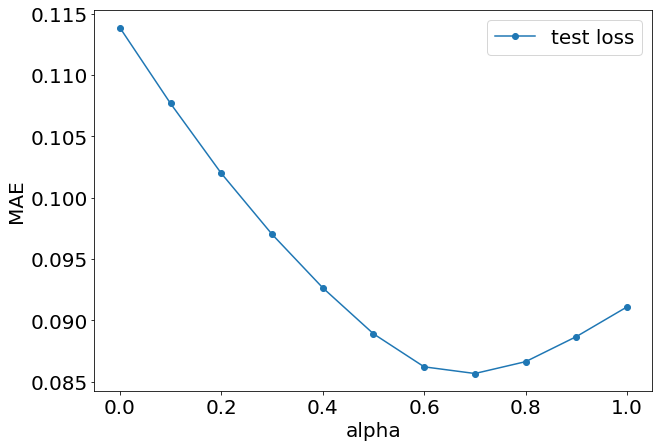

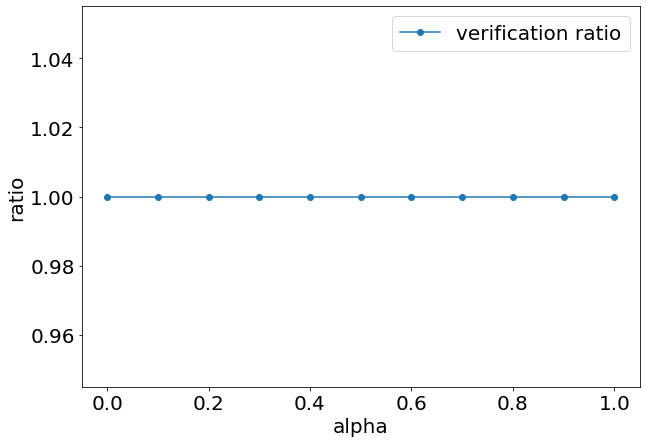

In [300]:
test_loss_alpha = []
test_ratio_alpha = []
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for _alpha in alphas:

    model.eval()

    with torch.no_grad():
        input_data = X_te[:,:input_dim]
        target_data = X_te[:,input_dim:]
        
        output = model(input_data, alpha=_alpha)
        
        test_loss = loss_task(output, target_data).item()  # sum up batch loss
        
        _, _, curr_E = calc_double_E(input_data, **params)
        _, _, next_E = calc_double_E(target_data, **params)
        _, _, pred_E = calc_double_E(output, **params)
        
        test_ratio = verification(curr_E, pred_E, threshold=0.0).item()

    print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss, _alpha))
    print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, _alpha))
    
    test_loss_alpha.append(test_loss)
    test_ratio_alpha.append(test_ratio)

    
    
plt.figure(0, figsize=(10,7))
plt.plot(alphas, test_loss_alpha, 'o-', label='test loss')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(alphas, test_ratio_alpha, 'o-', label='verification ratio')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

In [270]:
# model_data_only = model
# model_hybrid = model

In [95]:
torch.allclose(rule_weight, model.rule_encoder.net[0].weight)
# torch.allclose(data_weight, model.data_encoder.net[0].weight)

True


Test set: Average loss: 0.08566072



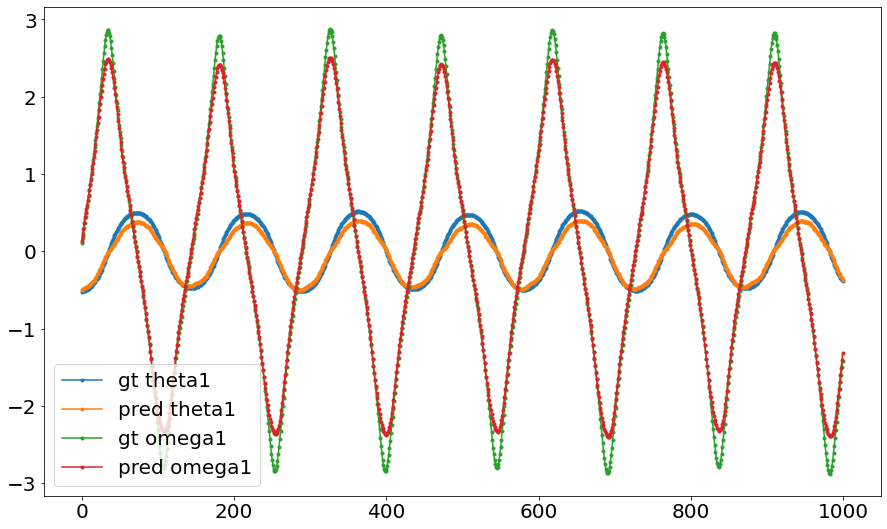

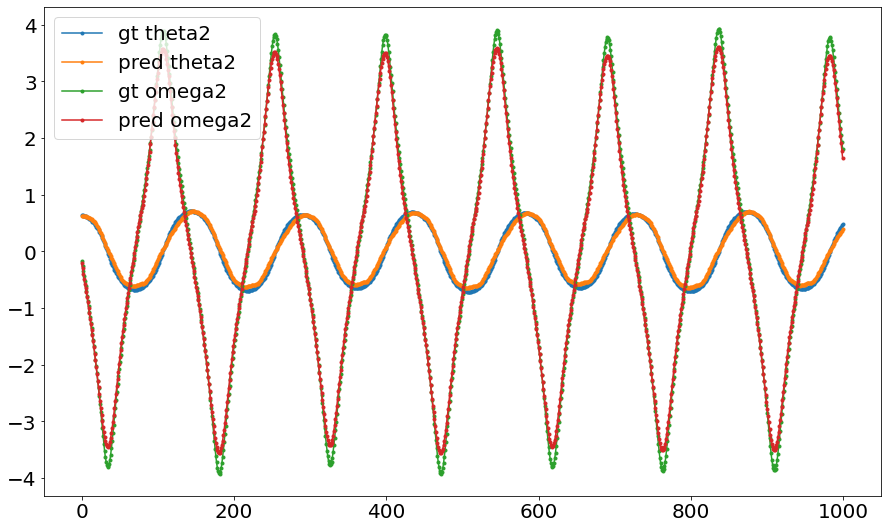

In [302]:
# Test
model.eval()
test_loss = 0
with torch.no_grad():
    target = X_te[:,input_dim:]
    output = model(X_te[:,:input_dim], alpha=0.7)
    test_loss = loss_task(output, target).item()  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))

plt.figure(0, figsize=(15,9))
plt.plot(target.cpu()[:1000,0], '.-', label='gt theta1')
plt.plot(output.cpu()[:1000,0], '.-', label='pred theta1')
plt.plot(target.cpu()[:1000,1], '.-', label='gt omega1')
plt.plot(output.cpu()[:1000,1], '.-', label='pred omega1')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.figure(1, figsize=(15,9))
plt.plot(target.cpu()[:1000,2], '.-', label='gt theta2')
plt.plot(output.cpu()[:1000,2], '.-', label='pred theta2')
plt.plot(target.cpu()[:1000,3], '.-', label='gt omega2')
plt.plot(output.cpu()[:1000,3], '.-', label='pred omega2')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

_, _, pred_E = calc_double_E(output, **params)

# loss_task(target.cpu()[:,0], output.cpu()[:,0])
# loss_task(target.cpu()[:,1], output.cpu()[:,1])
# loss_task(target.cpu()[:,2], output.cpu()[:,2])
# loss_task(target.cpu()[:,3], output.cpu()[:,3])

ratio of verified predictions: 1.000000


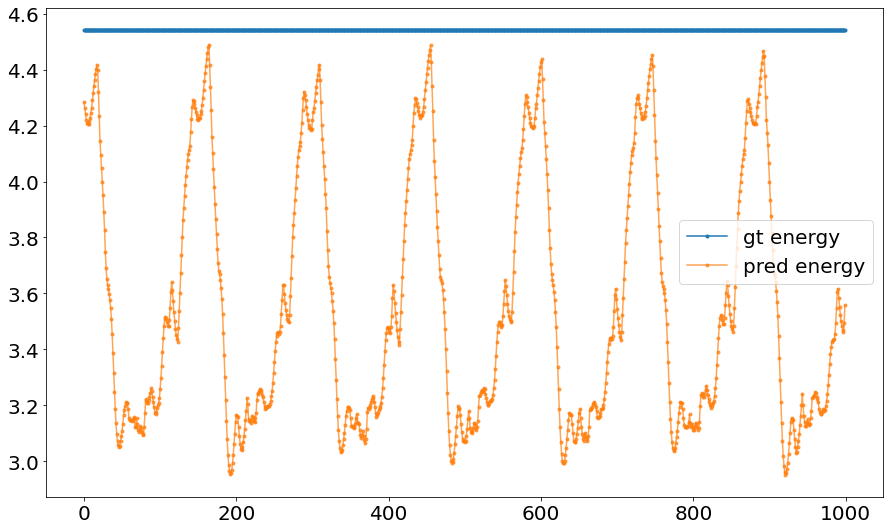

In [304]:
with torch.no_grad():
    input_data = X_te[:,:input_dim]
    target_data = X_te[:,input_dim:]
    output = model(input_data, alpha=0.7)

    _, _, curr_E = calc_double_E(input_data, **params)
    _, _, next_E = calc_double_E(target_data, **params)
    _, _, pred_E = calc_double_E(output, **params)


print("ratio of verified predictions: {:.6f}".format(verification(curr_E, pred_E, threshold=0.0).item()))

plt.figure(0, figsize=(15,9))
# plt.plot(curr_E.cpu()[:100], '.-', label='gt energy')
plt.plot(next_E.cpu()[:1000], '.-', label='gt energy')
plt.plot(pred_E.cpu()[:1000], '.-', alpha=0.7, label='pred energy')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

In [201]:
tind = 10
print("t state: {}".format(X_te[tind, :input_dim]))
print("t+1 state: {}".format(X_te[tind, input_dim:]))
with torch.no_grad():
    pred_state = model(X_te[tind,:input_dim])
print("t+1 prediction: {}\n".format(pred_state))

gt_energy = calc_double_E(X_te[tind,input_dim:], **params)
pred_energy = calc_double_E(pred_state, **params)
print("gt energy at t: {}".format(gt_energy[2]))
print("pred energy at t: {}".format(pred_energy[2]))



t state: tensor([ 0.4199,  3.2033, -0.4931, -0.9913], device='cuda:0')
t+1 state: tensor([ 0.4203,  3.2022, -0.4932, -0.9894], device='cuda:0')
t+1 prediction: tensor([ 0.4123,  3.1790, -0.5295, -0.9574], device='cuda:0')

gt energy at t: 11.68400764465332
pred energy at t: 11.761198043823242


In [166]:
calc_double_E(np.array([ 0.4203,  3.2022, -0.4932, -0.9894]), **params)

(2.87672871200267, 8.80780356830157, 11.68453228030424)

In [66]:
print(torch.allclose(rule_weight, torch.tensor(model.rule_encoder.net[0].weight)))

torch.allclose(data_weight, torch.tensor(model.data_encoder.net[0].weight))

False


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


True

In [192]:
torch.max(X_te[:,0]), torch.min(X_te[:,0])

(tensor(1.1110, device='cuda:0'), tensor(-1.1040, device='cuda:0'))

In [195]:
perturbations = []
input_energy = []
output_energy = []

target_attr_ind = 1

for ind in range(-50,50):
    max_val, min_val = torch.max(X_te[:,target_attr_ind]), torch.min(X_te[:,target_attr_ind])
    step = (max_val - min_val)*0.001
    delta_x = ind*step
    perturbations.append(delta_x)

    if target_attr_ind == 0:
        tmp_input = X_te[:1,:input_dim] + torch.tensor([[delta_x,0,0,0]]).to(device)    # theta1
    elif target_attr_ind == 1:
        tmp_input = X_te[:1,:input_dim] + torch.tensor([[0,delta_x,0,0]]).to(device)    # omega1
    elif target_attr_ind == 2:
        tmp_input = X_te[:1,:input_dim] + torch.tensor([[0,0,delta_x,0]]).to(device)    # theta2
    elif target_attr_ind == 3:
        tmp_input = X_te[:1,:input_dim] + torch.tensor([[0,0,0,delta_x]]).to(device)    # omega2
    
    print(tmp_input)
    print('tmp input energy: {}'.format(calc_double_E(tmp_input, **params)))

    with torch.no_grad():
        tmp_output = model(tmp_input)
        print(tmp_output)
        print('tmp output energy: {}'.format(calc_double_E(tmp_output, **params)))
        
        out_e = calc_double_E(tmp_output, **params)[2]
        in_e = calc_double_E(tmp_input, **params)[2]
        print(loss_rule(out_e, in_e))
        print('\n')
    
    
    input_energy.append(in_e)
    output_energy.append(out_e)

tensor([[ 0.0413,  3.9384, -0.2877, -3.1634]], device='cuda:0')
tmp input energy: (tensor([0.4200], device='cuda:0'), tensor([8.7240], device='cuda:0'), tensor([9.1440], device='cuda:0'))
tensor([[ 0.0508,  4.0363, -0.2271, -3.2806]], device='cuda:0')
tmp output energy: (tensor([0.2773], device='cuda:0'), tensor([8.9396], device='cuda:0'), tensor([9.2169], device='cuda:0'))
tensor(0.0729, device='cuda:0')


tensor([[ 0.0413,  3.9479, -0.2877, -3.1634]], device='cuda:0')
tmp input energy: (tensor([0.4200], device='cuda:0'), tensor([8.7704], device='cuda:0'), tensor([9.1904], device='cuda:0'))
tensor([[ 0.0512,  4.0405, -0.2264, -3.2785]], device='cuda:0')
tmp output energy: (tensor([0.2761], device='cuda:0'), tensor([8.9606], device='cuda:0'), tensor([9.2368], device='cuda:0'))
tensor(0.0464, device='cuda:0')


tensor([[ 0.0413,  3.9573, -0.2877, -3.1634]], device='cuda:0')
tmp input energy: (tensor([0.4200], device='cuda:0'), tensor([8.8170], device='cuda:0'), tensor([9.2369], device='

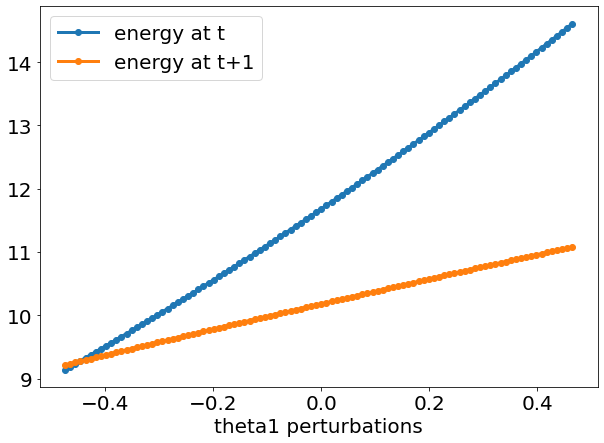

In [196]:
plt.figure(0, figsize=(10,7))
plt.plot(perturbations, input_energy, 'o-', lw=3, label='energy at t')
plt.plot(perturbations, output_energy, 'o-', lw=3, label='energy at t+1')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('theta1 perturbations', fontsize=20)
plt.legend(fontsize=20)

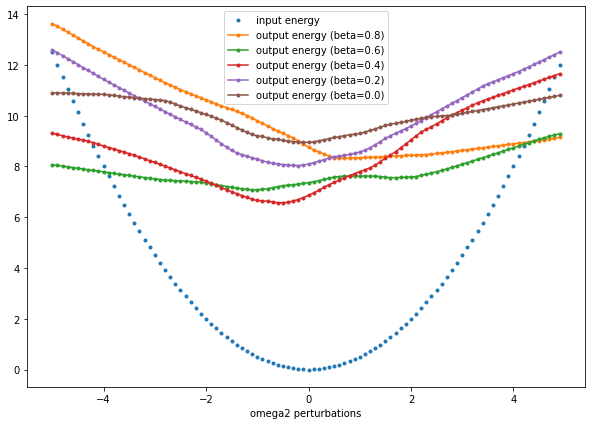

In [189]:
plt.figure(0, figsize=(10,7))
plt.plot(perturbations, input_energies[6], '.', label='input energy')
# plt.plot(perturbations, input_energies[1], '.', label='input energy')

# plt.plot(perturbations, output_energies[0], '.-', label='output energy (beta=1.0)')
plt.plot(perturbations, output_energies[1], '.-', label='output energy (beta=0.8)')
plt.plot(perturbations, output_energies[2], '.-', label='output energy (beta=0.6)')
plt.plot(perturbations, output_energies[3], '.-', label='output energy (beta=0.4)')
plt.plot(perturbations, output_energies[4], '.-', label='output energy (beta=0.2)')
plt.plot(perturbations, output_energies[6], '.-', label='output energy (beta=0.0)')
plt.xlabel('omega2 perturbations')
plt.legend()

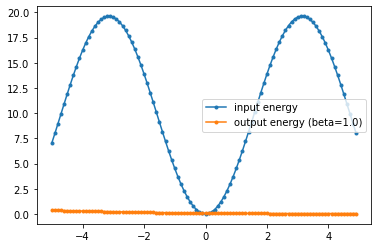

In [149]:
plt.plot(perturbations, input_energy, '.-', label='input energy')
plt.plot(perturbations, output_energy, '.-', label='output energy (beta=1.0)')
plt.xlabel('theta2 perturbations')
plt.legend()

In [1]:
class RuleEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RuleEncoder, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim,32),
                                 nn.ReLU(),
                                 nn.Linear(32,output_dim),
                                 nn.Tanh())
        
    def forward(self, x):
        return self.net(x)

    
class DataEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DataEncoder, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim,32),
                                 nn.ReLU(),
                                 nn.Linear(32,output_dim),
                                 nn.Tanh())
        
    def forward(self, x):
        return self.net(x)


class Net(nn.Module):
    def __init__(self, input_dim, output_dim, rule_encoder, data_encoder):
        super(Net, self).__init__()
        self.rule_encoder = rule_encoder
        self.data_encoder = data_encoder
        self.net = nn.Sequential(nn.Linear(input_dim,32),
                                 nn.ReLU(),
                                 nn.Linear(32,output_dim))
        
    def forward(self, x, alpha=0.0):
        rule_z = self.rule_encoder(x)
        data_z = self.data_encoder(x)
        
#         z = alpha*rule_z + (1-alpha)*data_z    # merge: Add
        z = torch.cat((alpha*rule_z, (1-alpha)*data_z), dim=-1)    # merge: Concat
        
#         return self.net(z) + x    # predict delta instead of absolute values
        return self.net(z)    # predict absolute values
    

input_dim = 4
hidden_dim = 16
output_dim = 4

lr = 0.0001
rule_encoder = RuleEncoder(input_dim, hidden_dim)
data_encoder = DataEncoder(input_dim, hidden_dim)
model = Net(hidden_dim*2, output_dim, rule_encoder, data_encoder).to(device)

rule_weight = torch.tensor(model.rule_encoder.net[0].weight)
data_weight = torch.tensor(model.data_encoder.net[0].weight)

total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

loss_rule = lambda x,y: torch.mean(F.relu(x-y))
loss_task = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)


epochs = 50
log_interval = 200
beta = 0.0
alpha = 0.0

# Training
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data, target = data[:,:input_dim], data[:,input_dim:]    # check
        
        optimizer.zero_grad()
        alpha = torch.rand(1).item()
#         alpha = 0.0    # data-only
        output = model(data, alpha=alpha)    # only rule if alpha=1
        
        _, _, curr_E = calc_double_E(data, **params)
        _, _, pred_E = calc_double_E(output, **params)
        _, _, target_E = calc_double_E(target, **params)
                
        loss_state = loss_task(output, target)    # state prediction
#         loss_energy = loss_task(pred_E, target_E)    # energy prediction
        loss_cons = loss_rule(pred_E, curr_E)    # energy conservation

        
    
        loss = alpha*loss_cons + (1-alpha)*loss_state    # energy conservation + state prediction

        
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} (alpha: {})'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), alpha))

# Test
model.eval()
test_loss = 0
with torch.no_grad():
    target = X_te[:,input_dim:]
    output = model(X_te[:,:input_dim], alpha=0.0)
    test_loss = loss_task(output, target).item()  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))

NameError: name 'nn' is not defined